# Import một số thư viện ban đầu và dữ liệu

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Đọc dữ liệu và phân tích dữ liệu bước đầu

In [15]:
df = pd.read_csv('cyberbullying_tweets.csv')
df.sample(10)

,tweet_text,cyberbullying_type
44317,“@JaaaacK__: man fuck these bitch ass niggers ...,ethnicity
29690,Last night I was meeting so many people and th...,other_cyberbullying
18412,> Another fine surprise was the existence of a...,religion
6429,#MKR host Collin Fassnidge and #Yahoo7 editor ...,not_cyberbullying
30343,RT @AmyDentata: Similar to how a woman merely ...,other_cyberbullying
4897,"@mcclure111 eek (also hi, i followed you becau...",not_cyberbullying
26630,RT @KinkyKevD: I hate that stupid fucking face...,other_cyberbullying
37672,Don’t let those who try to intimidate you with...,age
28405,@Pleasure__Kevin @SteampunkKanye i don't reall...,other_cyberbullying
29385,@Coley_Cee: Let me make a couple tweets off cu...,other_cyberbullying


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [17]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

Phân lớp gồm 6 lớp: not_cyberbullying là không phải bắt nạt; gender, religion, age, ethnicity là các kiểu bắt nạt theo giới tính, tôn giáo, tuổi, sắc tộc; other_cyberbullying là các loại bắt nạt khác

In [18]:
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

Mỗi lớp có khoảng 7900 dòng dữ liệu

Drop cột other, vì nó là class ko rõ ràng, dễ làm nhầm lẫn vs các class khác

In [19]:
df.drop(df[df['cyberbullying_type'] == 'other_cyberbullying'].index, inplace = True)
df['cyberbullying_type'].value_counts()

religion             7998
age                  7992
gender               7973
ethnicity            7961
not_cyberbullying    7945
Name: cyberbullying_type, dtype: int64

### Visualization bước đầu

In [20]:
df['cyberbullying_type'].value_counts()

religion             7998
age                  7992
gender               7973
ethnicity            7961
not_cyberbullying    7945
Name: cyberbullying_type, dtype: int64

<Axes: ylabel='None'>

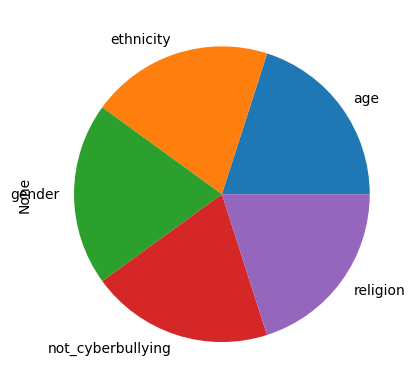

In [21]:
df.groupby('cyberbullying_type').size().plot(kind='pie')

Ta thấy số lượng dữ liệu trên các phân lớp khá cân bằng, nên hiện tại chưa cần xử lý cân bằng dữ liệu

# Tiền xử lý dữ liệu

In [22]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [23]:
df.sample(10)

,text,sentiment
45877,"The post was like ""White: no colored ppl here ...",ethnicity
17065,@BilalIGhumman @98Halima @johnnygjokaj @cdnKha...,religion
42652,"@SwagDonors ""Outsiders"" vision is colored by r...",ethnicity
38299,"yes, kinda like that. the title of the movie i...",age
7758,@garbage_person @thisonesakillaa You said as m...,not_cyberbullying
2443,Muz's Kitchen Rules #MKR http://t.co/wFpjjQy6Fa,not_cyberbullying
38753,Girl that bullied you in high school just got ...,age
20856,Unfortunately until we confront the idiots tha...,religion
14942,Hate seeing the pervasive anal rape jokes arou...,gender
7760,"Well said, Manu. #mkr",not_cyberbullying


Mã hóa các phân lớp thành số

In [24]:
df["sentiment"].replace({"religion": 1, "age": 2, "gender": 3, "ethnicity": 4, "not_cyberbullying": 5}, inplace=True)

In [25]:
sentiments = ["religion","age","gender","ethnicity","not bullying"]


### Xử lý, làm sạch text

Dữ liệu sử dụng là các tweet của người dùng, thường sẽ chứa nhiều thành phần gây nhiễu. Để mô hình đưa ra dự đoán chính xác nhất ta cần loại bỏ các nhiễu này. Các loại nhiễu bao gồm:

* URLs
* Hashtags
* Mentions
* Reserved words (RT, FAV)
* Emojis

Các bước làm sạch text được thực hiện bao gồm:
* Loại bỏ emoji
* Decontact (VD: Chuyển can't -> can not)
* Loại bỏ các entities (\n, \r, chuyển hết thành lowercase, loại bỏ link và mention, kí tự lỗi, ...)
* Loại bỏ hashtag (thêm vào cuối câu, bỏ #)
* Loại bỏ dấu lỗi (các kí tự $, %, ...)
* Thực hiện stemming
* Thực hiện lemmentization

In [27]:
#Text cleaning
import re, string
import demoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

#Clean emojis from text
def strip_emoji(text):
    return demoji.replace(text, '') #remove emoji

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [28]:
texts_cleaned = []
for t in df.text:
    texts_cleaned.append(preprocess(t))

In [29]:
df['text_clean'] = texts_cleaned

In [30]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",5,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,5,aussietv white mkr theblock today sunris studi...
2,@XochitlSuckkks a classy whore? Or more red ve...,5,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",5,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,5,isi account pretend kurdish account like islam...


### Loại bỏ các dữ liệu lặp

In [31]:
df["text_clean"].duplicated().sum()

1049

In [32]:
df.drop_duplicates("text_clean", inplace=True)

In [33]:
df.sentiment.value_counts()

1    7946
2    7884
4    7746
5    7637
3    7607
Name: sentiment, dtype: int64

### Kiểm tra độ dài tweet

In [34]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [35]:
df['text_len'] = text_len

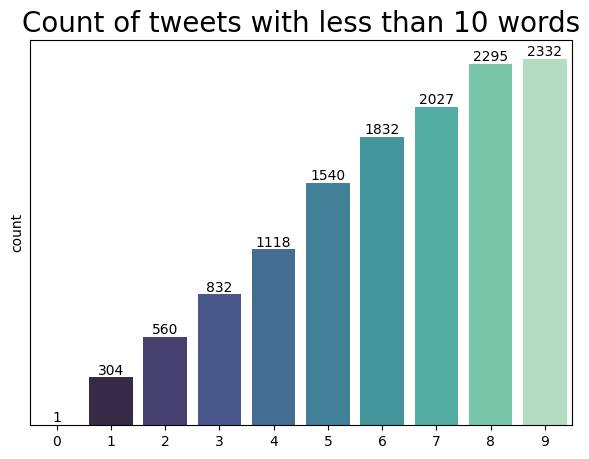

In [36]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [37]:
# checking long tweets
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,4,black white tri live like nigger pahahahaha co...,187
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",4,fuck obama dumb ass nigger bitch ltthi whore s...,162
33724,"... I don't feel guilty for killing him, I jus...",2,feel guilti kill feel guilti enjoy torment sin...,137
1317,@EurekAlertAAAS: Researchers push to import to...,5,research push import top antibulli program us ...,137
47037,@Purely_Ambition: Sooo mad. RT @TracePeterson ...,4,sooo mad rt fuck obama dumb nigger go switzerl...,125
...,...,...,...,...
1607,@harmlesstree2 Here7 https://t.co/xWJzpSodGj,5,here7,1
6696,@LiamTighe Rebecca who?,5,rebecca,1
558,@root_tim this is my work :),5,work,1
3462,@jaredchase killing you how?,5,kill,1


### Loại bỏ các ngoại lai

Các tweet có độ dài dưới 3 từ và trên 100 từ sẽ được coi là ngoại lai vì chúng xuất hiện ít và sẽ ảnh hưởng tới hiệu năng dự đoán nếu giữ lại.

In [38]:
df = df[df['text_len'] > 3]
df = df[df['text_len'] < 100]

In [39]:
df

,text,sentiment,text_clean,text_len
0,"In other words #katandandre, your food was cra...",5,word katandandr food crapilici mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,5,aussietv white mkr theblock today sunris studi...,10
2,@XochitlSuckkks a classy whore? Or more red ve...,5,classi whore red velvet cupcak,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",5,meh p thank head concern anoth angri dude twitter,9
4,@RudhoeEnglish This is an ISIS account pretend...,5,isi account pretend kurdish account like islam...,8
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",4,black ppl expect anyth depend anyth yet free p...,21
47688,Turner did not withhold his disappointment. Tu...,4,turner withhold turner call court abomin concl...,28
47689,I swear to God. This dumb nigger bitch. I have...,4,swear god dumb nigger bitch got bleach hair re...,13
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,4,yea fuck rt your nigger fuck unfollow fuck dum...,10


### Visualize các lớp bằng wordcloud

In [40]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# import matplotlib.pyplot as plt #to display our wordcloud
# from PIL import Image #to load our image
# import numpy as np #to get the color of our image

0 - religion </br> 1 - age </br> 2 - gender </br> 3 - ethnicity </br> 4 - cyberbullying


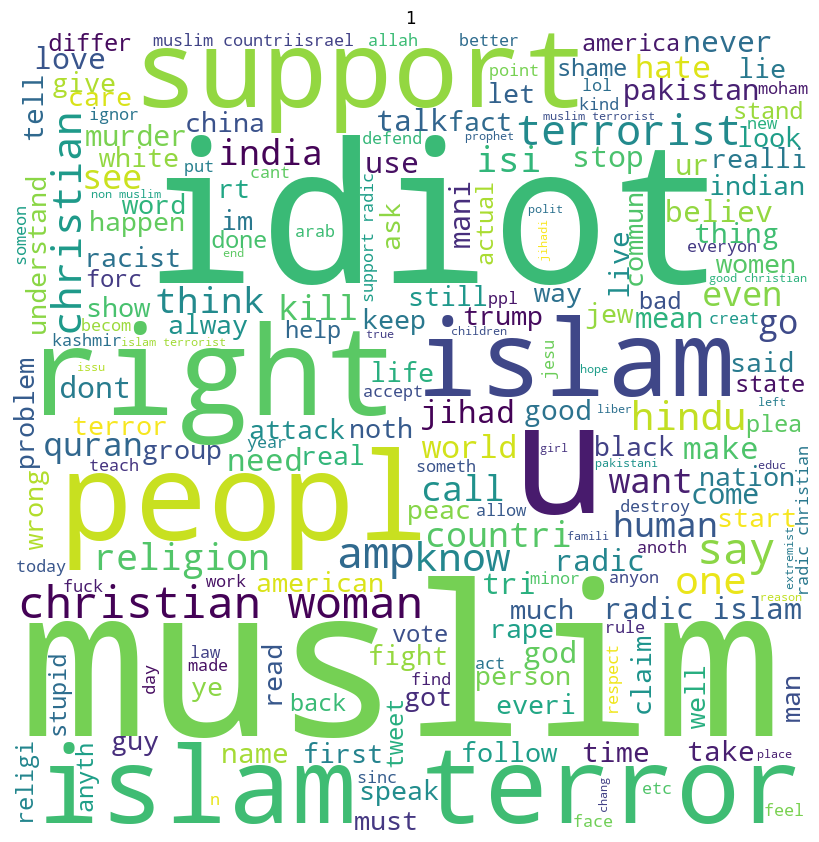

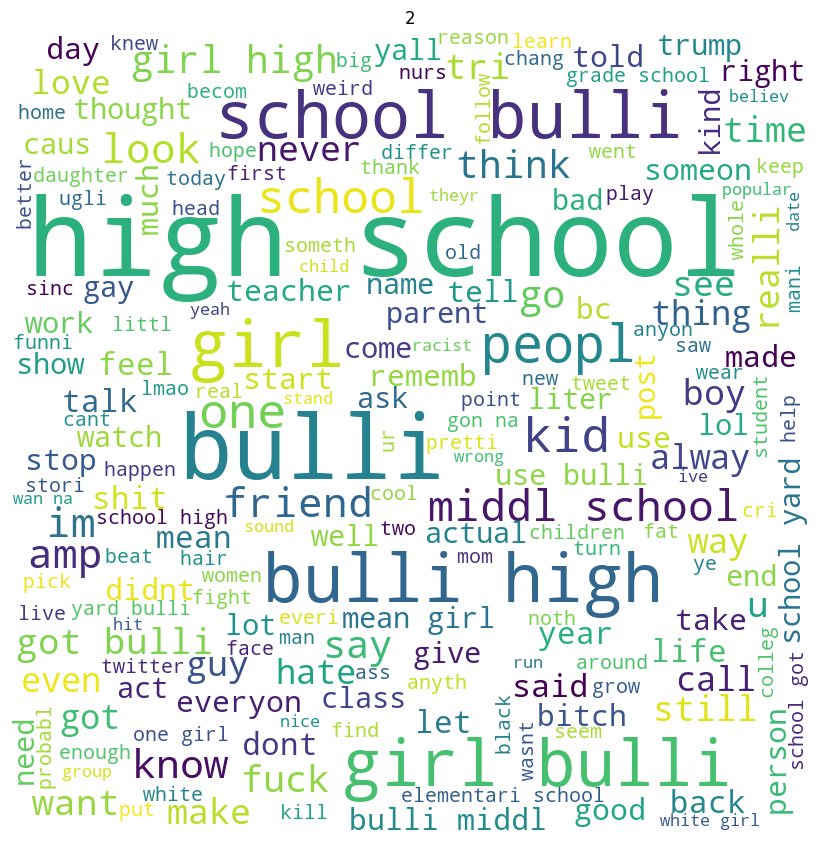

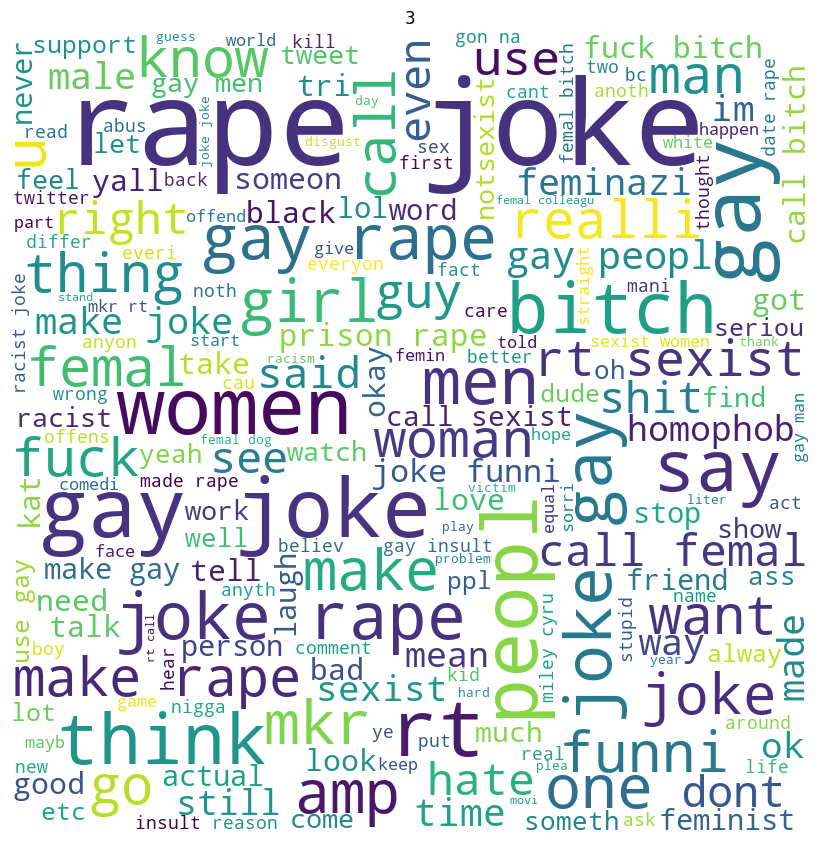

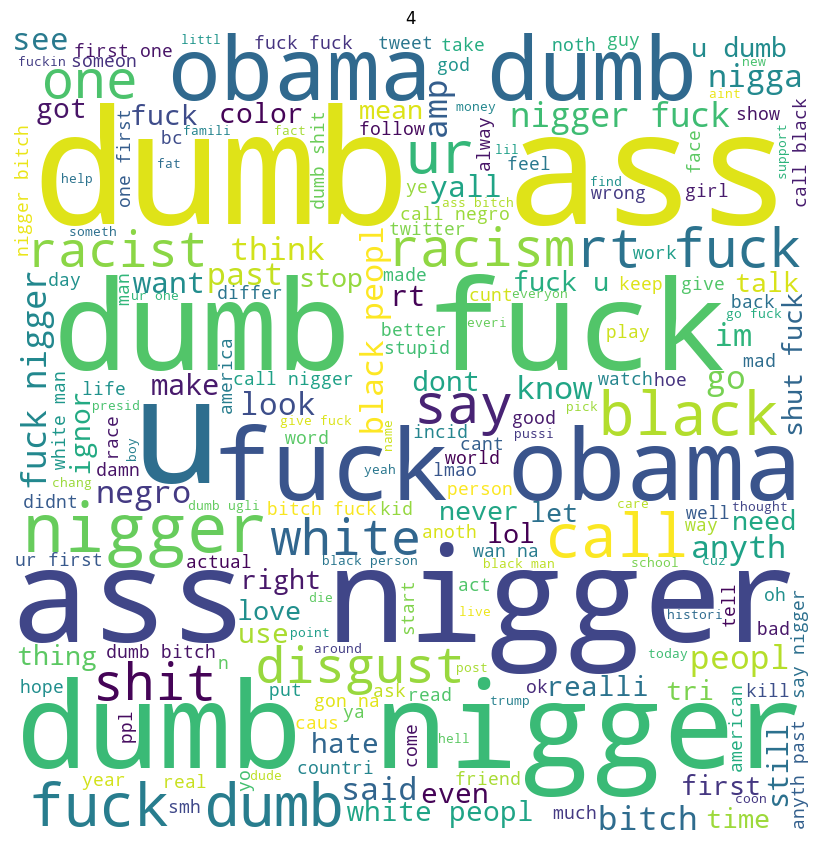

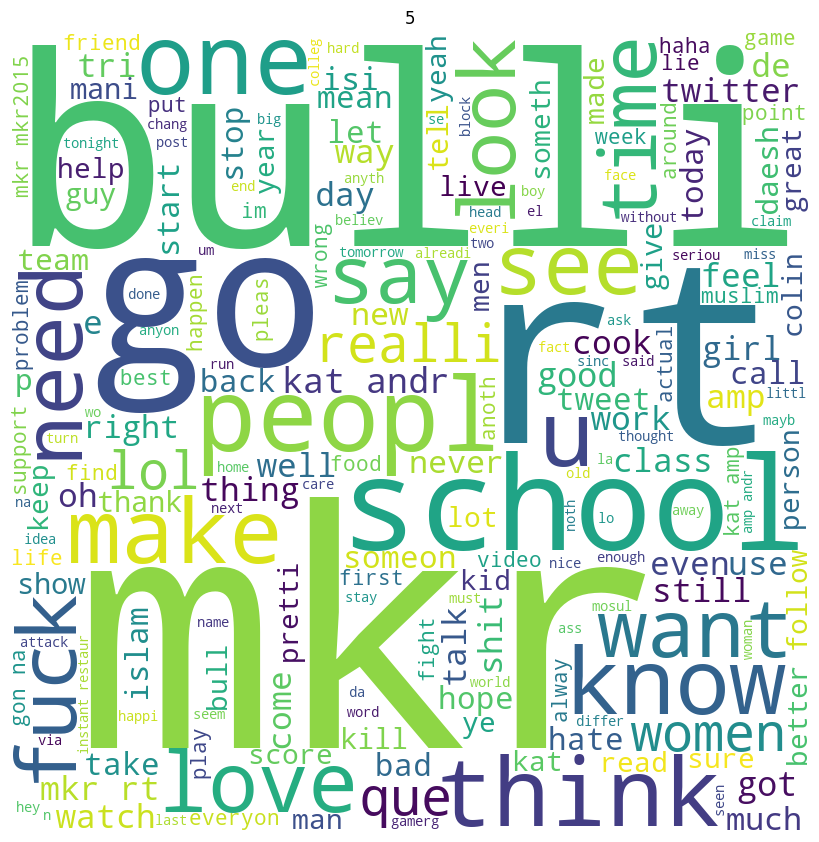

In [41]:
from sklearn.preprocessing import LabelEncoder

lenc = LabelEncoder()
df.sentiment = lenc.fit_transform(df.sentiment)

for c in range(len(lenc.classes_)):
    string = ""
    for i in df[df.sentiment == c].text_clean.values:
        string = string + " " + i.strip()

    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(string)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(lenc.classes_[c])
    plt.show()
    del string

#### Chuyển đổi dữ liệu từ text sang số bằng TF-IDF

In [42]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline


tfidf = TfidfTransformer()
clf = CountVectorizer()

X_cv =  clf.fit_transform(df['text_clean'])

tf_transformer = TfidfTransformer(use_idf=True).fit(X_cv)
X_tf = tf_transformer.transform(X_cv)

In [43]:
X_tf

<37114x32979 sparse matrix of type '<class 'numpy.float64'>'
	with 504608 stored elements in Compressed Sparse Row format>

### Tách dữ liệu thành tập train và test

In [44]:
from sklearn.model_selection import train_test_split
# train and test
X_train, X_test, y_train, y_test = train_test_split(X_tf, df['sentiment'], test_size=0.20, stratify=df['sentiment'], random_state=42)

In [45]:
y_train.value_counts()

0    6314
1    6264
3    6167
2    5849
4    5097
Name: sentiment, dtype: int64

Sau khi loại bỏ dữ liệu lặp và ngoại lai, ta thấy lượng dữ liệu giữa các lớp không còn cân bằng nữa, vì vậy ta sẽ cân bằng dữ liệu bằng cách oversampling với SMOTE

In [46]:
from imblearn.over_sampling import SMOTE
vc = y_train.value_counts()
while (vc[0] != vc[4]) or (vc[0] !=  vc[2]) or (vc[0] !=  vc[3]) or (vc[0] !=  vc[1]):
    smote = SMOTE(sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)
    vc = y_train.value_counts()

y_train.value_counts()

4    6314
0    6314
3    6314
2    6314
1    6314
Name: sentiment, dtype: int64

# Đưa dữ liệu vào huấn luyện các mô hình

Mô hình Multinomial Naive Bayes

In [47]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

MultinomialNB()

Mô hình Cây Quyết Định

In [48]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion = 'entropy')
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

Mô hình SVM tuyến tính

In [49]:
from sklearn.svm import LinearSVC
sv_clf = LinearSVC()
sv_clf.fit(X_train, y_train)

LinearSVC()

# Đánh giá các mô hình

### Precision, recall, f1-score, accuracy

In [50]:
from sklearn.metrics import classification_report
nb_pred = nb_clf.predict(X_test)
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.85      0.97      0.91      1579
         age       0.80      0.98      0.88      1566
      gender       0.89      0.85      0.87      1462
   ethnicity       0.90      0.91      0.90      1542
not bullying       0.84      0.49      0.62      1274

    accuracy                           0.85      7423
   macro avg       0.85      0.84      0.84      7423
weighted avg       0.85      0.85      0.84      7423



In [51]:
dt_pred = dt_clf.predict(X_test)
print('Classification Report for Decision Tree:\n',classification_report(y_test, dt_pred, target_names=sentiments))

Classification Report for Decision Tree:
               precision    recall  f1-score   support

    religion       0.95      0.93      0.94      1579
         age       0.97      0.97      0.97      1566
      gender       0.91      0.87      0.89      1462
   ethnicity       0.98      0.98      0.98      1542
not bullying       0.77      0.83      0.80      1274

    accuracy                           0.92      7423
   macro avg       0.92      0.92      0.92      7423
weighted avg       0.92      0.92      0.92      7423



In [52]:
sv_pred = sv_clf.predict(X_test)
print('Classification Report for SVM:\n',classification_report(y_test, sv_pred, target_names=sentiments))

Classification Report for SVM:
               precision    recall  f1-score   support

    religion       0.96      0.94      0.95      1579
         age       0.95      0.97      0.96      1566
      gender       0.93      0.88      0.91      1462
   ethnicity       0.98      0.98      0.98      1542
not bullying       0.78      0.84      0.81      1274

    accuracy                           0.92      7423
   macro avg       0.92      0.92      0.92      7423
weighted avg       0.93      0.92      0.92      7423



Mô hình SVM tuyến tính có độ chính xác cao nhất với 93%, sau đó là cây quyết định và naive bayes với 91% và 85%.

### Kiểm định chéo

In [53]:
from sklearn.model_selection import cross_val_score

NB_cv_score = cross_val_score(nb_clf,X_train, y_train, cv=3)
DT_cv_score = cross_val_score(dt_clf,X_train, y_train, cv=3)
SVM_cv_score = cross_val_score(sv_clf,X_train, y_train, cv=3)

print('Cross validation score (Multinomial Naive Bayes Classifier):', NB_cv_score.mean())
print('Cross validation score (Decision Tree):', DT_cv_score.mean())
print('Cross validation score (SVM):', SVM_cv_score.mean())

Cross validation score (Multinomial Naive Bayes Classifier): 0.8483054813032608
Cross validation score (Decision Tree): 0.9157427855959854
Cross validation score (SVM): 0.9318025525500307
